# Predictive Analytics - Project 2

## 1. Introduction

**Import libraries**

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set_style('darkgrid')

**Load data**

In [41]:
data = pd.read_csv('data/heloc_dataset_v1.csv')

In [42]:
print(data.shape)
data.head(3)

(10459, 24)


,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
RiskPerformance                       10459 non-null object
ExternalRiskEstimate                  10459 non-null int64
MSinceOldestTradeOpen                 10459 non-null int64
MSinceMostRecentTradeOpen             10459 non-null int64
AverageMInFile                        10459 non-null int64
NumSatisfactoryTrades                 10459 non-null int64
NumTrades60Ever2DerogPubRec           10459 non-null int64
NumTrades90Ever2DerogPubRec           10459 non-null int64
PercentTradesNeverDelq                10459 non-null int64
MSinceMostRecentDelq                  10459 non-null int64
MaxDelq2PublicRecLast12M              10459 non-null int64
MaxDelqEver                           10459 non-null int64
NumTotalTrades                        10459 non-null int64
NumTradesOpeninLast12M                10459 non-null int64
PercentInstallTrades                  10459 non-null int64
MSinc

## 2. EDA

## 3. Modeling

### 3.1. Data preprocessing

In [44]:
dummies.columns

Index(['MaxDelq2PublicRecLast12M_0', 'MaxDelq2PublicRecLast12M_1',
       'MaxDelq2PublicRecLast12M_2', 'MaxDelq2PublicRecLast12M_3',
       'MaxDelq2PublicRecLast12M_4', 'MaxDelq2PublicRecLast12M_5',
       'MaxDelq2PublicRecLast12M_6', 'MaxDelq2PublicRecLast12M_7',
       'MaxDelq2PublicRecLast12M_9', 'MaxDelqEver_2', 'MaxDelqEver_3',
       'MaxDelqEver_4', 'MaxDelqEver_5', 'MaxDelqEver_6', 'MaxDelqEver_7',
       'MaxDelqEver_8'],
      dtype='object')

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Specify X and y
X = data.drop('RiskPerformance', axis=1)
y = data.RiskPerformance

# Factorizing `y`
y = y.map({'Bad': 1, 'Good': 0})

# One-hot encode for 'MaxDelq2PublicRecLast12M' and 'MaxDelqEver'
dummies = pd.get_dummies(X[['MaxDelq2PublicRecLast12M', 'MaxDelqEver']].astype(str), drop_first=True)
X.drop(['MaxDelq2PublicRecLast12M', 'MaxDelqEver'], axis=1, inplace=True)

# One-hot encode for -7, -8, -9 values
def get_special_dummies(X, col):
  """
  One-hot encode for -7, -8, -9 values in each column
  """
  X[col + '_-7'] = X[col].apply(lambda row:int(row==-7))
  X[col + '_-8'] = X[col].apply(lambda row:int(row==-8))
  X[col + '_-9'] = X[col].apply(lambda row:int(row==-9))

for col in X.columns:
    get_special_dummies(X, col)

# Concatenate X and dummies
X = pd.concat([X, dummies], axis=1)

# Replace negative values with NaN
X[X < 0] = np.nan

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1)
# Imputing Missing Values and Feature Scaling
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Feature scaling
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### 3.2. Modeling

In [46]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

def gridSearchCV(model, params):
    """
    @param    model: sklearn estimator
    @param    params (dict): Dictionary of possible parameters
    
    @return   cv_results (DataFrame)
    """
    model_cv = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=5)
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]
    
    return cv_results

In [47]:
def evaluate(model, plotROC=False):
    """
    1. Plot ROC AUC of the test set
    2. Return the best threshold
    """
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    # Find optimal threshold
    rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
    rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
    optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]
    
    # Get accuracy over the test set
    y_pred = np.where(preds >= optimalThreshold, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    if plotROC:
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

#### 3.2.1. Random Forest

In [48]:
params = {'n_estimators': [50, 200]}
rfc = RandomForestClassifier(random_state=1)
print(gridSearchCV(rfc, params))

                  params  mean_test_score
0   {'n_estimators': 50}         0.783394
1  {'n_estimators': 200}         0.789508


AUC: 0.7981
Accuracy: 74.00%


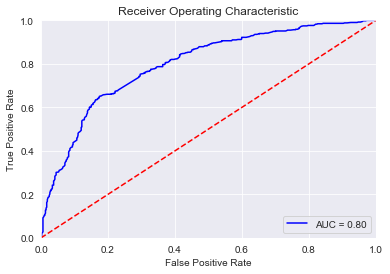

In [49]:
rfc = RandomForestClassifier(n_estimators=500, random_state=1)
evaluate(rfc, plotROC=True)

#### 3.2.2. Logistic Regression

In [50]:
params = {'C': [0.01, 0.1, 1, 10]}
logit = LogisticRegression()
print(gridSearchCV(logit, params))

        params  mean_test_score
0  {'C': 0.01}         0.796635
1   {'C': 0.1}         0.796564
2     {'C': 1}         0.796482
3    {'C': 10}         0.796407


AUC: 0.7992
Accuracy: 72.94%


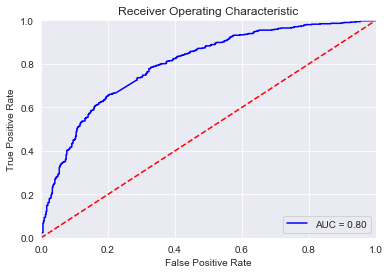

In [51]:
logit = LogisticRegression(C=0.01)
evaluate(logit, plotROC=True)

#### 3.2.3. LightGBM

In [52]:
params = {'max_depth': [5, 6, 7]}
lightGBM = LGBMClassifier(learning_rate=0.05,
                          n_estimators=150,
                          num_leaves=8,
                          min_data_in_leaf=4,
                          max_depth=5,
                          max_bin=55,
                          bagging_fraction=0.78,
                          bagging_freq=5,
                          feature_fraction=0.24,
                          feature_fraction_seed=9,
                          bagging_seed=9,
                          min_sum_hessian_in_leaf=11)
print(gridSearchCV(lightGBM, params))

             params  mean_test_score
0  {'max_depth': 5}         0.798398
1  {'max_depth': 6}         0.798203
2  {'max_depth': 7}         0.798521


AUC: 0.7997
Accuracy: 72.85%


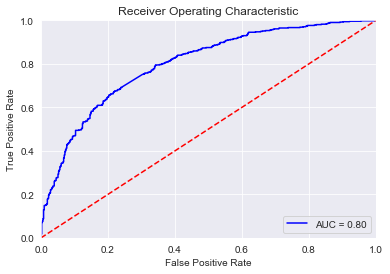

In [53]:
lightGBM = LGBMClassifier(learning_rate=0.05,
                          n_estimators=200,
                          num_leaves=7,
                          min_data_in_leaf=4,
                          max_depth=4,
                          max_bin=55,
                          bagging_fraction=0.78,
                          bagging_freq=9,
                          feature_fraction=0.24,
                          feature_fraction_seed=9,
                          bagging_seed=9,
                          min_sum_hessian_in_leaf=13)
evaluate(lightGBM, plotROC=True)

#### 3.2.4. SVM

In [54]:
params = {'C': [0.1, 1, 3, 10]}
svc = SVC(gamma='auto', random_state=1)
print(gridSearchCV(svc, params))

       params  mean_test_score
0  {'C': 0.1}         0.787765
1    {'C': 1}         0.787651
2    {'C': 3}         0.782655
3   {'C': 10}         0.773760


AUC: 0.7919
Accuracy: 72.56%


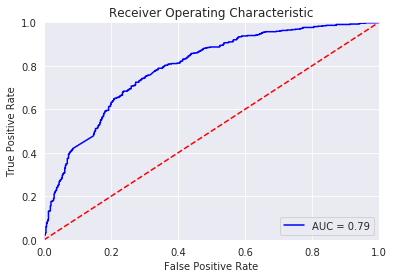

In [60]:
svc = SVC(C=0.1, kernel='linear', degree=2,
          gamma=0.1, random_state=1, probability=True)
evaluate(svc, plotROC=True)

#### 3.2.5. Averaging Model

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])
        # Average predictions
        predictions = np.mean(predictions, axis=1)
        predictions = np.where(predictions >= 0.5, 1, 0)
        return predictions
    
    def predict_proba(self, X):
        # Get predictions from trained clone models
        probs_1 = np.column_stack(
            [model.predict_proba(X)[:, 1] for model in self.models_])
        # Average predictions
        probs_1 = np.mean(probs_1, axis=1)
        probs_0 = 1 - probs_1
        probs = np.column_stack([probs_0, probs_1])
        return probs

AUC: 0.8019
Accuracy: 73.04%


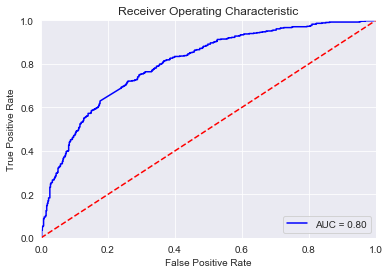

In [ ]:
avg_model = AveragingModel([lightGBM, rfc, svc])
evaluate(avg_model, plotROC=True)

## 3.3. Save the final model

In [ ]:
from sklearn.pipeline import Pipeline
import joblib

def save_model(model, model_name):
    print('Saving ' + model_name + ' ...')
    pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler()),
                               ('model', model)])
    pipeline.fit(X, y)
    filename = 'models/' + model_name + '.joblib.pkl'
    joblib.dump(pipeline, filename, compress=9)
    print('Complete!\n')

In [64]:
save_model(logit, 'logit')
save_model(rfc, 'rfc')
save_model(svc, 'svc')
save_model(lightGBM, 'lgbm')

Saving logit ...
Complete!

Saving rfc ...
Complete!

Saving svc ...
Complete!

Saving lgbm ...
Complete!



In [ ]:
### Load models
#import joblib
#model_name = 'lgbm'
#filename = 'models/' + model_name + '.joblib.pkl'
#model = joblib.load(filename)